# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
from gwpy.timeseries import TimeSeries
import copy

## Data

Download data

In [24]:
home_dir = "./MDC_waveforms/"

In [25]:
H_filename = "H-H1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"
L_filename = "L-L1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"

In [26]:
H_waveform = TimeSeries.read(home_dir + H_filename, 'H1:NR_INJECTED')
L_waveform = TimeSeries.read(home_dir + L_filename, 'L1:NR_INJECTED')

## Particular realisation

In [9]:
H_data = np.load("Systematics_MDC_Realisation0_H.npz")
L_data = np.load("Systematics_MDC_Realisation0_L.npz")

In [10]:
H_waveform = qnm_filter.Data(H_data['values'], index = H_data['index'])
L_waveform = qnm_filter.Data(L_data['values'], index = L_data['index'])

## Filter

In [11]:
input = dict(model_list = [(2, 2, 0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 1126259461.9935195, #SSB start time #1126259462.4083147, #GW150914 start time
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [12]:
fit.original_data['H1'] = H_waveform
fit.original_data['L1'] = L_waveform
fit.detector_alignment()

In [13]:
import lal
tgps = lal.LIGOTimeGPS(fit.t_init)
location = lal.cached_detector_by_prefix['L1'].location
dt_ifo = lal.TimeDelayFromEarthCenter(location, fit.ra, fit.dec, tgps)

In [14]:
idx = np.argmax(fit.original_data['L1'].values)
time = fit.original_data['L1'].index[idx]

(1126259461.9512208, 1126259462.0512207)

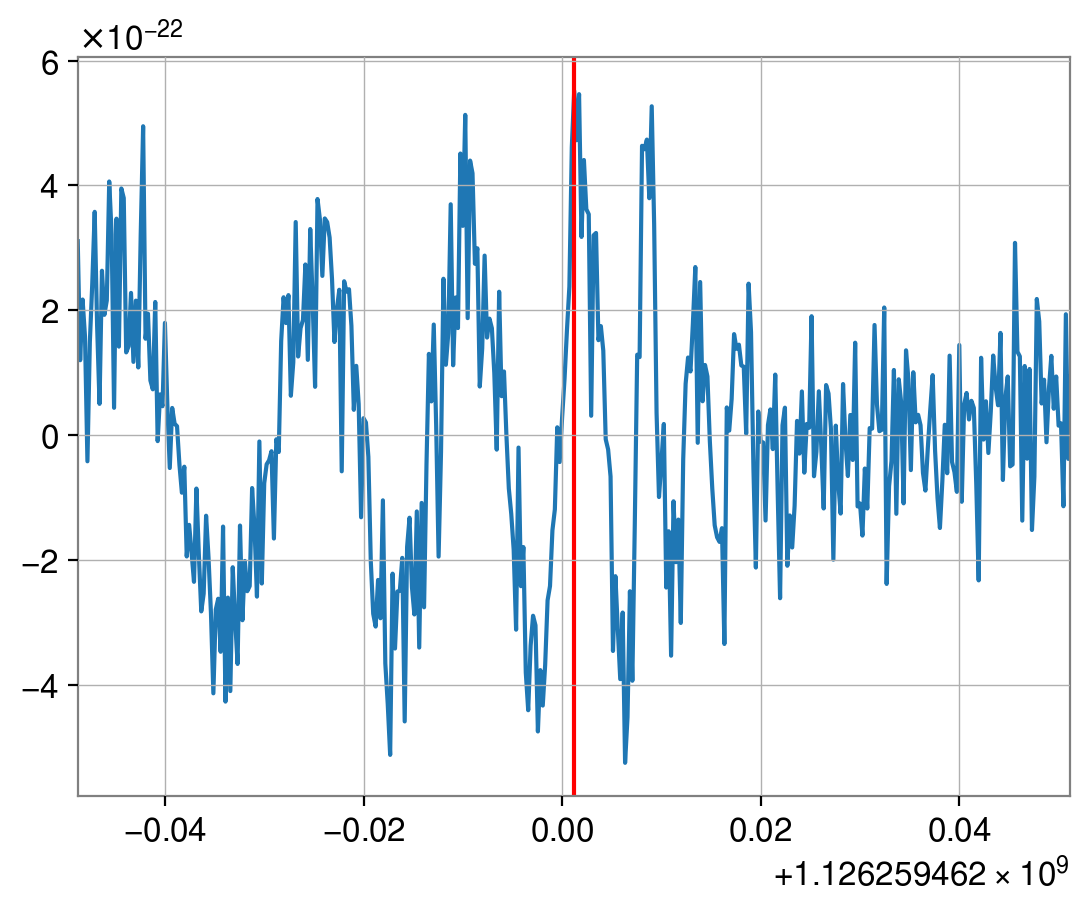

In [15]:
fit.original_data['L1'].plot()
pl.axvline(fit.start_times['L1'], c='r')
pl.xlim(time - 5e-2, time + 5e-2)

(1126259461.9512208, 1126259462.0512207)

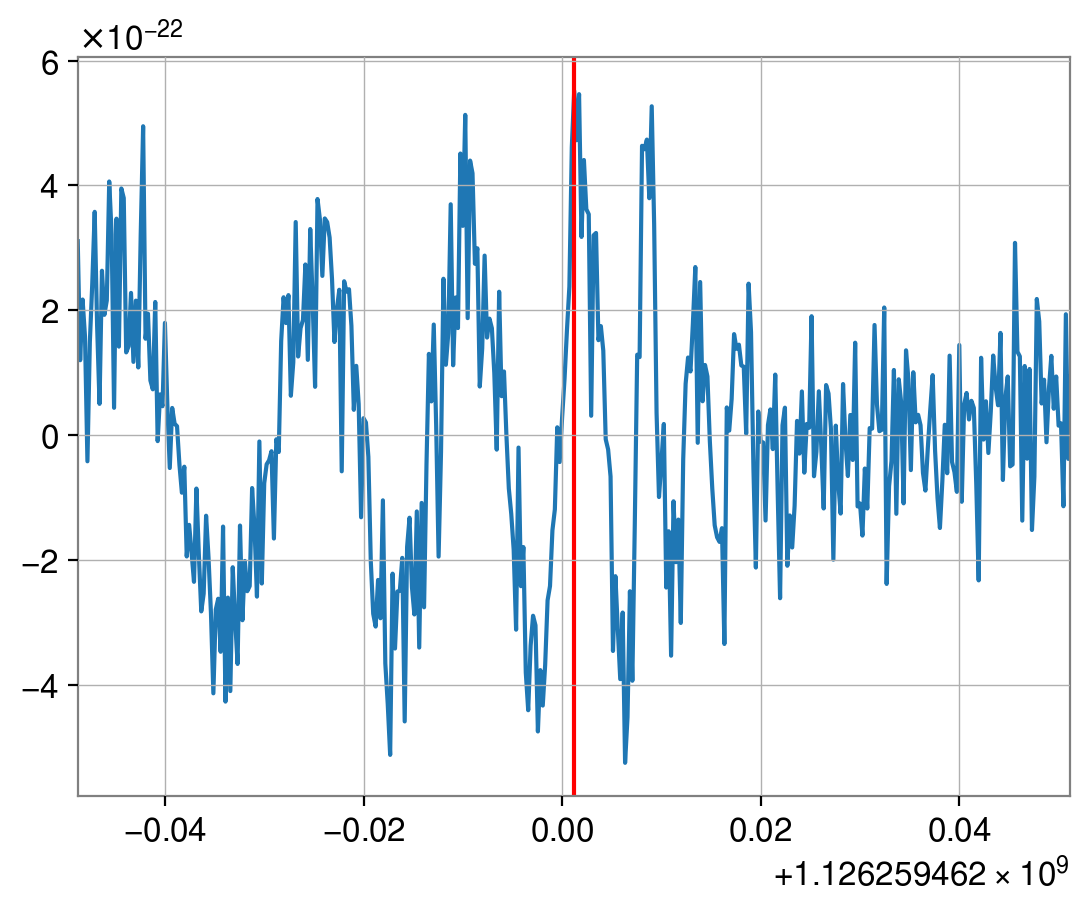

In [16]:
fit.original_data['L1'].plot()
pl.axvline(fit.start_times['L1'], c='r')
pl.xlim(time - 5e-2, time + 5e-2)

In [17]:
SSB_start_time = time - dt_ifo
tgps = lal.LIGOTimeGPS(SSB_start_time)
location = lal.cached_detector_by_prefix['H1'].location
dt_ifo = lal.TimeDelayFromEarthCenter(location, fit.ra, fit.dec, tgps)

H_start_time = SSB_start_time+dt_ifo

(1126259461.9582052, 1126259462.0582051)

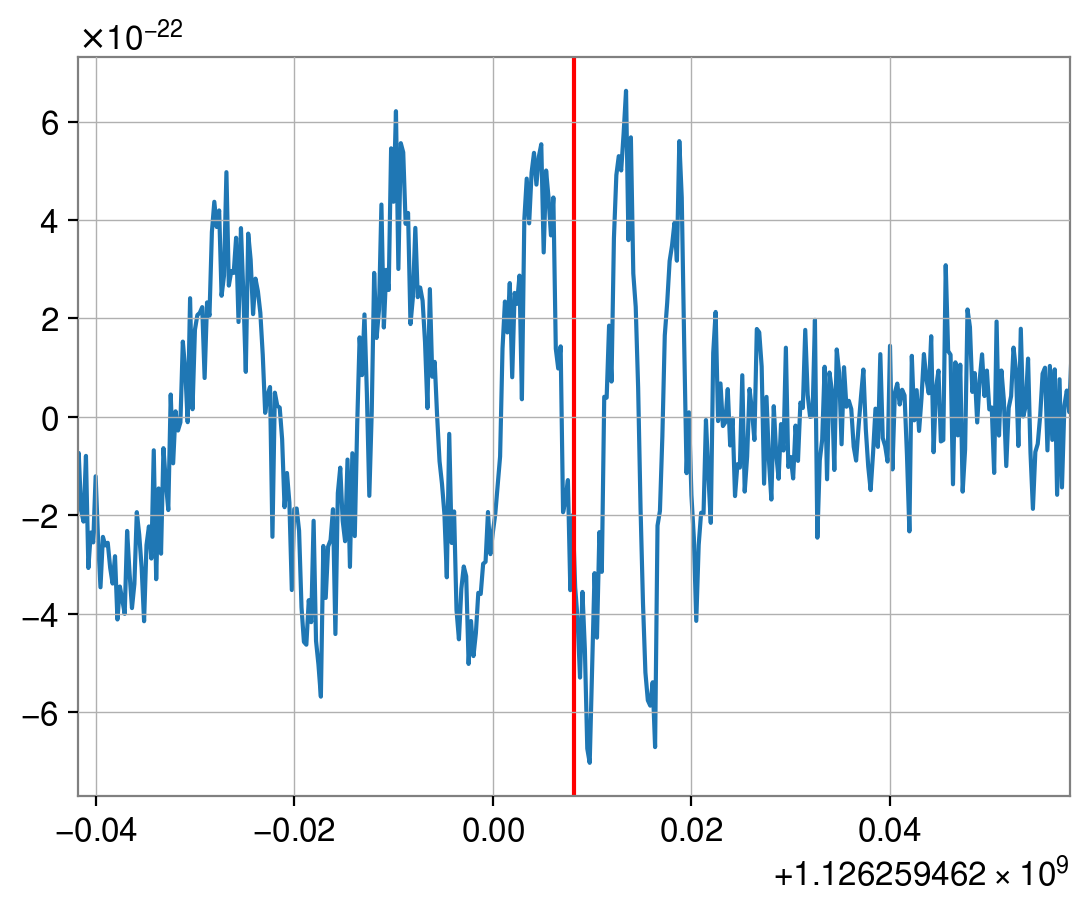

In [19]:
fit.original_data['H1'].plot()
pl.axvline(H_start_time, c='r')
pl.xlim(H_start_time - 5e-2, H_start_time + 5e-2)

In [20]:
SSB_start_time

1126259461.9935195

## SNR

In [23]:
fit.condition_data('original_data')
fit.compute_acfs('original_data')
fit.cholesky_decomposition()

In [35]:
trim = int(3*len(H_data)/4)
fit.waveforms = {}
fit.waveforms['H1'] = qnm_filter.Data(H_waveform.value[trim:], index = H_waveform.times[trim:])
fit.waveforms['L1'] = qnm_filter.Data(L_waveform.value[trim:], index = L_waveform.times[trim:])

In [52]:
fit.condition_data('waveforms')

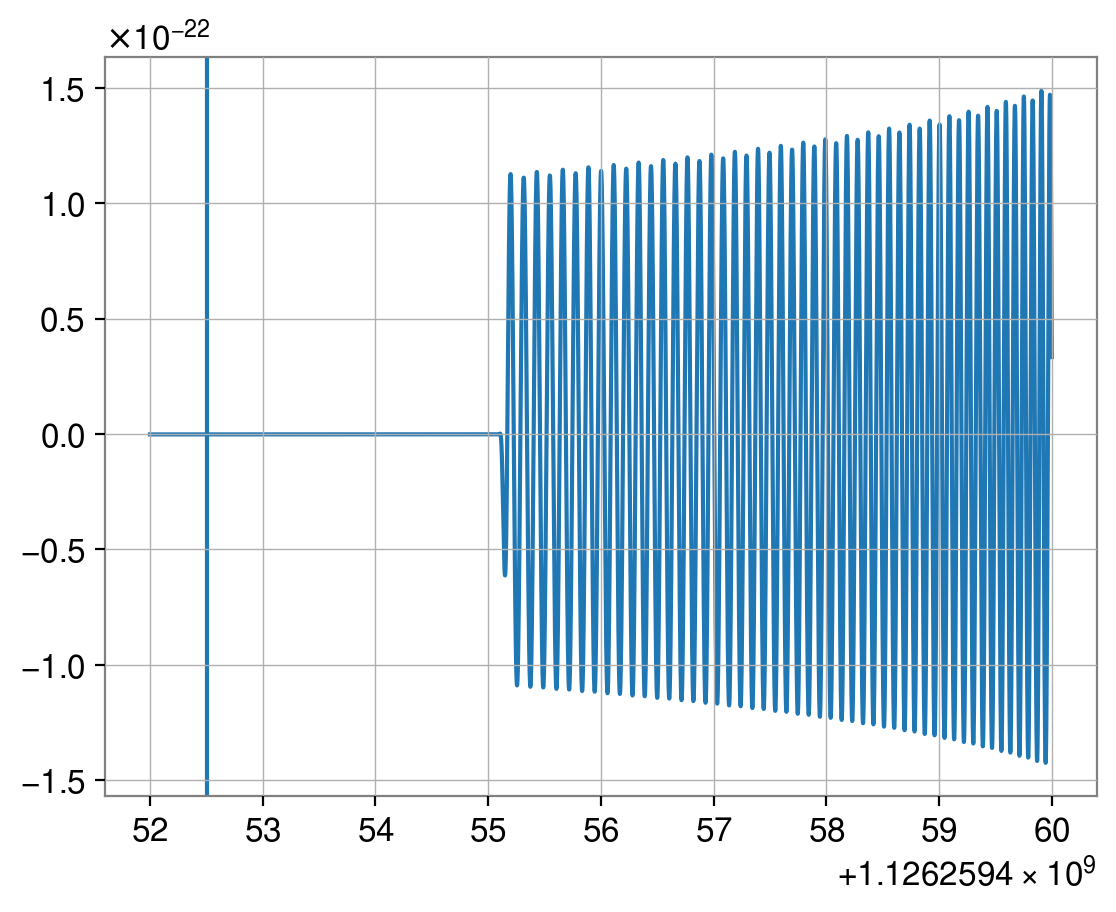

In [53]:
fit.waveforms['H1'].plot()
pl.axvline(fit.waveforms['H1'].index[fit.i0_dict['H1']])

In [47]:
fit.first_index()
test = fit.truncate_data(fit.waveforms)

In [48]:
fit.i0_dict

{'H1': 2082, 'L1': 2053}

In [49]:
fit.start_times

{'H1': 1126259462.0082052, 'L1': 1126259462.0012207}

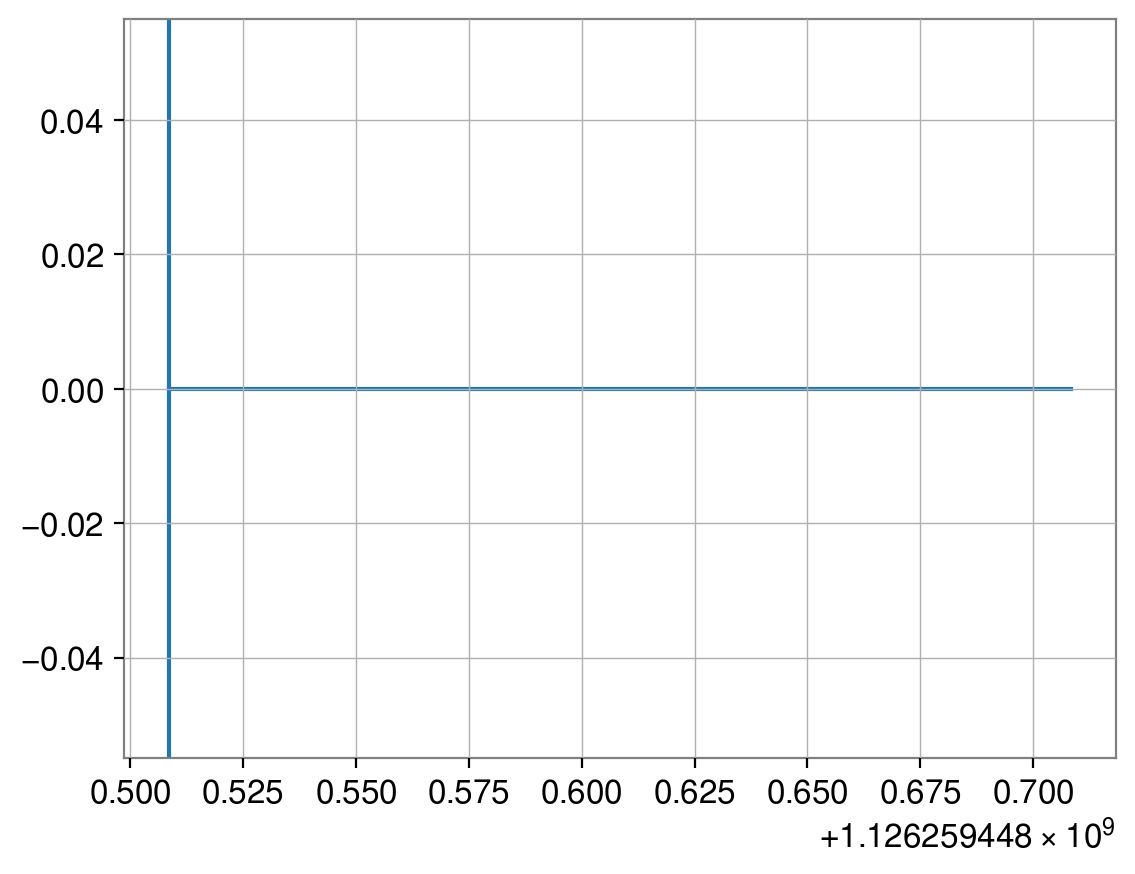

In [50]:
test['H1'].plot()
pl.axvline(fit.waveforms['H1'].index[fit.i0_dict['H1']])

In [21]:
fit.first_index()
snipped = fit.truncate_data(fit.original_data)

In [ ]:
pl.plot(snipped['L1'])

In [ ]:
temp_H = fit.original_data['H1']
temp_idx = np.argmax(temp_H.values)
index_window = int(0.13*fit.sampling_n)
SNR_H = temp_H.values[temp_idx:temp_idx+index_window]
SNR_noise = fit.pure_noise['H1'].values[temp_idx:temp_idx+index_window]

In [ ]:
pl.plot(SNR_H)
pl.plot(SNR_noise)

In [ ]:
SNR = np.sum(np.abs(SNR_H)**2) / np.sum(np.abs(SNR_noise)**2)
print("SNR = %.2f" % SNR)

In [73]:
3e-3/qnm_filter.Filter.mass_unit(68.5)

8.891625404149647